In [1]:
!python --version

Python 3.9.13


In [2]:
# Módulos estándar de Python
import logging
import string
import unicodedata
from collections import Counter
from itertools import chain

# Módulos de terceros (paquetes instalados con pip)
import nltk
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import transformers

# Tipado estático
from typing import List, Union

In [3]:
# Configuración del logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
# Cargar el dataset
df = pd.read_json('yelp_academic_dataset_review.json', lines=True)


In [6]:
# Tomar una porción de 1.2 millones de datos del dataset original para evitar mayor computo
df_sample = df.sample(n=1_200_000, random_state=42)

In [ ]:
# Guardar el nuevo subconjunto para compartir o reutilizar
df_sample.to_csv("subset_1.2M.csv", index=False)

In [13]:
# Lo cargamos de nuevo para renombrar y reiniciar el valor de los indices del dataframe
df = pd.read_csv("subset_1.2M.csv")

In [14]:
df

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,J5Q1gH4ACCj6CtQG7Yom7g,56gL9KEJNHiSDUoyjk2o3Q,8yR12PNSMo6FBYx1u5KPlw,2,1,0,0,Went for lunch and found that my burger was me...,2018-04-04 21:09:53
1,HlXP79ecTquSVXmjM10QxQ,bAt9OUFX9ZRgGLCXG22UmA,pBNucviUkNsiqhJv5IFpjg,5,0,0,0,I needed a new tires for my wife's car. They h...,2020-05-24 12:22:14
2,JBBULrjyGx6vHto2osk_CQ,NRHPcLq2vGWqgqwVugSgnQ,8sf9kv6O4GgEb0j1o22N1g,5,0,0,0,Jim Woltman who works at Goleta Honda is 5 sta...,2019-02-14 03:47:48
3,U9-43s8YUl6GWBFCpxUGEw,PAxc0qpqt5c2kA0rjDFFAg,XwepyB7KjJ-XGJf0vKc6Vg,4,0,0,0,Been here a few times to get some shrimp. The...,2013-04-27 01:55:49
4,8T8EGa_4Cj12M6w8vRgUsQ,BqPR1Dp5Rb_QYs9_fz9RiA,prm5wvpp0OHJBlrvTj9uOg,5,0,0,0,This is one fantastic place to eat whether you...,2019-05-15 18:29:25
...,...,...,...,...,...,...,...,...,...
1199995,lEECc-tQkSVHQr27ZwQXiA,KyjGiDiXPizjePw8mr8dZA,-cEFKAznWmI0cledNOIQ7w,1,2,0,0,I've been here a couple of times now like 20 s...,2019-04-18 17:57:57
1199996,JBfsepben7ftWjBGHVeBfw,hle5qSJwiGX9I0EFyM64-A,Dk8CFB8_odno0N0lmT8lwA,3,0,0,0,This place has a really odd smell maybe it's d...,2019-02-03 06:38:13
1199997,EuMs7Nd6_KpJBWgN67qm0w,R_H58n9FOEosWz0Nogh0yA,G5EiTYvAPMlFyFRBzP7TxQ,3,0,0,0,I went to target today to get me a swimcap. Th...,2018-06-20 01:55:30
1199998,4Vj96eVrKGXVDDz7aTbqKg,N_WB5usUFVBYI_8g7nnh-g,ju1qrGJ1mcc1sc2oRX7X5g,3,0,0,0,The tacos were excellent. I ordered the steak ...,2011-08-08 02:21:06


In [15]:
# Filtrar solo las columnas necesarias
df = df[['text', 'stars']]

In [16]:
# Mostrar primeras filas
df.head()

,text,stars
0,Went for lunch and found that my burger was me...,2
1,I needed a new tires for my wife's car. They h...,5
2,Jim Woltman who works at Goleta Honda is 5 sta...,5
3,Been here a few times to get some shrimp. The...,4
4,This is one fantastic place to eat whether you...,5


In [17]:
# Mostrar información general
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1200000 non-null  object
 1   stars   1200000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 18.3+ MB
None


In [18]:
# Revisar valores nulos
print(df.isnull().sum())

text     0
stars    0
dtype: int64


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


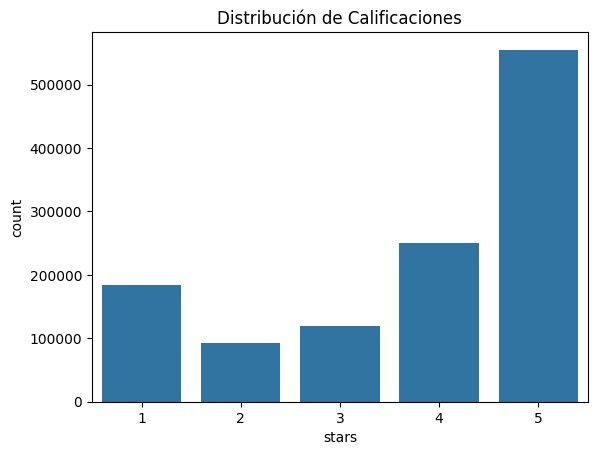

In [19]:
# Distribución de estrellas
sns.countplot(x=df['stars'])
plt.title("Distribución de Calificaciones")
plt.show()

In [20]:
# Ver estadísticas de la variable 'stars'
print(df['stars'].describe())

count    1.200000e+06
mean     3.748801e+00
std      1.478783e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: stars, dtype: float64


In [21]:
# Contar cuántas reseñas hay por cada calificación
print(df['stars'].value_counts())

stars
5    554855
4    249525
1    183691
3    118637
2     93292
Name: count, dtype: int64


In [22]:
# Crear una nueva columna con la cantidad de palabras en cada reseña
df['review_length'] = df['text'].apply(lambda x: len(x.split()))

C:\Users\JuanSebastianArbelae\AppData\Local\Temp\ipykernel_14448\1580490676.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_length'] = df['text'].apply(lambda x: len(x.split()))


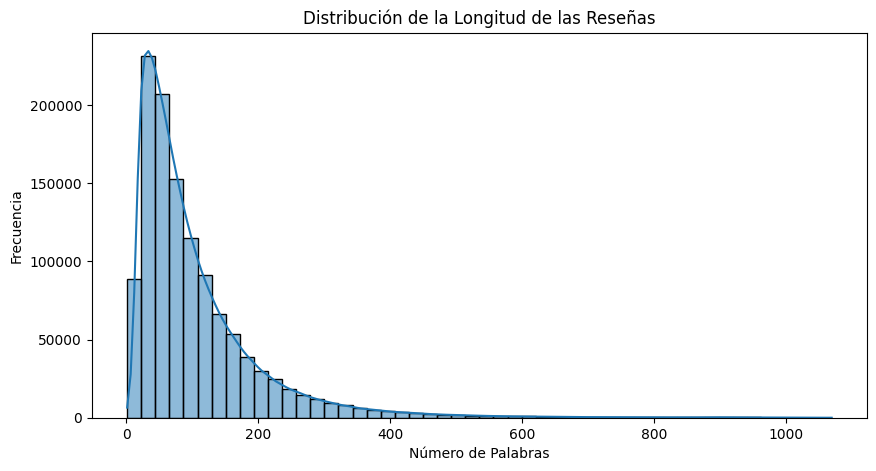

In [23]:
# Visualizar la distribución de la longitud de las reseñas
plt.figure(figsize=(10,5))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title("Distribución de la Longitud de las Reseñas")
plt.xlabel("Número de Palabras")
plt.ylabel("Frecuencia")
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


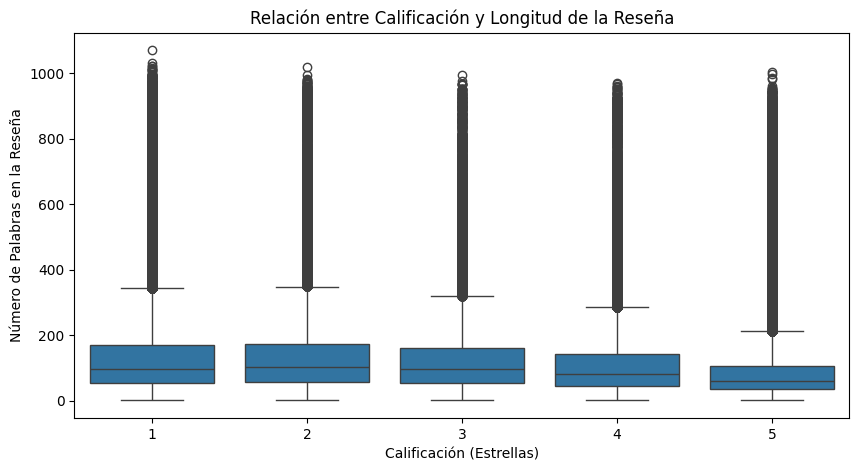

In [24]:
# Relacion entre longitud de texto y calificacion
plt.figure(figsize=(10,5))
sns.boxplot(x=df['stars'], y=df['review_length'])
plt.title("Relación entre Calificación y Longitud de la Reseña")
plt.xlabel("Calificación (Estrellas)")
plt.ylabel("Número de Palabras en la Reseña")
plt.show()

In [17]:
# Unir todas las reseñas en un solo string
all_reviews = " ".join(df['text'])

In [ ]:
# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

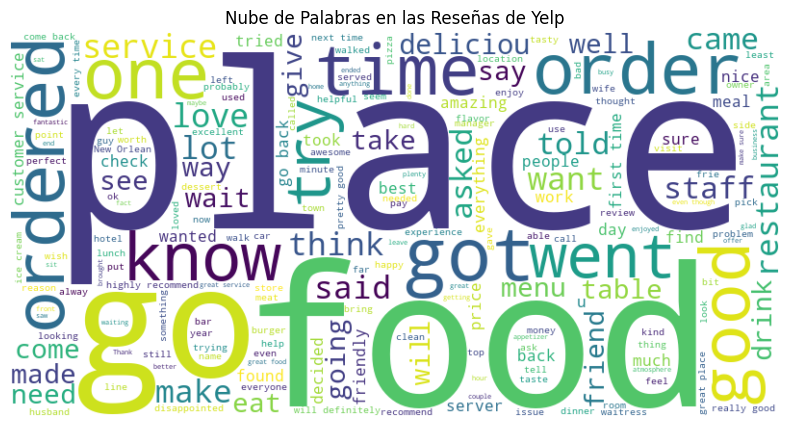

In [ ]:
# Mostrar la nube de palabras
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de Palabras en las Reseñas de Yelp")
plt.show()

In [25]:
# Empezamos a trabajar sobre las stopwords para disminuir el ruido de los datos
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JuanSebastianArbelae\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Instalamos el modelo de spacy
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------------- -------------------------- 4.5/12.8 MB 24.4 MB/s eta 0:00:01
     ------------------------------ -------- 10.0/12.8 MB 24.8 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 22.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
# Cargamos el modelo de spacy para parte del preprocesamiento
nlp = spacy.load("en_core_web_sm")

In [37]:
def normalize_text(text: str) -> str:
    """
    Normaliza el texto eliminando tildes y caracteres especiales.
    """
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8")
    return text

def clean_text(text: str, stop_words: set[str] = stop_words) -> List[str]:
    """
    Limpia y normaliza un texto dado:
    - Convierte a minúsculas.
    - Elimina puntuación y caracteres especiales.
    - Elimina acentos y tildes.
    - Aplica lematización.
    - Filtra stop words.

    Args:
        text (str): Texto de entrada.
        stop_words (set[str], opcional): Conjunto de stop words a eliminar. 
                                         Por defecto, usa STOP_WORDS.

    Returns:
        List[str]: Lista de palabras limpias y normalizadas.

    Raises:
        ValueError: Si la entrada no es una cadena de texto.
    """
    if not isinstance(text, str):
        raise ValueError("El texto de entrada debe ser una cadena de caracteres.")

    #logger.info("Limpiando y normalizando el texto...")

    # Convertir a minúsculas y eliminar tildes
    text = normalize_text(text.lower())

    # Eliminar signos de puntuación
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Procesar con spaCy para tokenización y lematización
    doc = nlp(text)
    words = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_punct]

    #logger.info("Texto limpiado y normalizado correctamente.")

    return words

In [38]:
# Aplicar la limpieza al dataset
df['clean_words'] = df['text'].apply(clean_text)

C:\Users\JuanSebastianArbelae\AppData\Local\Temp\ipykernel_14448\1618390823.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_words'] = df['text'].apply(clean_text)


In [40]:
df.to_csv("clean_data.csv", index=False)

In [41]:
df

,text,stars,review_length,clean_words
0,Went for lunch and found that my burger was me...,2,78,"[go, lunch, find, burger, meh, , obvious, foc..."
1,I needed a new tires for my wife's car. They h...,5,55,"[need, new, tire, wife, car, special, order, n..."
2,Jim Woltman who works at Goleta Honda is 5 sta...,5,38,"[jim, woltman, work, goleta, honda, 5, star, k..."
3,Been here a few times to get some shrimp. The...,4,30,"[time, get, shrimp, , get, nice, selection, d..."
4,This is one fantastic place to eat whether you...,5,40,"[one, fantastic, place, eat, whether, hungry, ..."
...,...,...,...,...
1199995,I've been here a couple of times now like 20 s...,1,199,"[couple, time, like, 20, since, open, really, ..."
1199996,This place has a really odd smell maybe it's d...,3,44,"[place, really, odd, smell, maybe, dirty, food..."
1199997,I went to target today to get me a swimcap. Th...,3,39,"[go, target, today, get, swimcap, 1, 10, websi..."
1199998,The tacos were excellent. I ordered the steak ...,3,74,"[taco, excellent, order, steak, taco, get, 3, ..."


In [ ]:
def clean_word_list(words: List[str]) -> List[str]:
    """
    Limpia una lista de palabras eliminando espacios en blanco, signos de puntuación y números.

    Args:
        words (List[str]): Lista de palabras a limpiar.

    Returns:
        List[str]: Lista de palabras sin espacios vacíos, signos de puntuación ni números.
    """
    return list(filter(None, map(lambda word: word.strip() if word and word not in string.punctuation and not word.isdigit() else None, words)))

In [48]:
df["clean_words"] = df["clean_words"].apply(clean_word_list)

C:\Users\JuanSebastianArbelae\AppData\Local\Temp\ipykernel_14448\4085546199.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["clean_words"] = df["clean_words"].apply(clean_word_list)


In [49]:
# Contar palabras más comunes en todo el dataset
word_counts = Counter(chain.from_iterable(df["clean_words"]))

In [50]:
# Mostrar las 20 palabras más frecuentes
most_common_words = word_counts.most_common(20)
print(most_common_words)

[('not', 857143), ('good', 761073), ('get', 687278), ('go', 635616), ('food', 628190), ('place', 616053), ('great', 528159), ('time', 484053), ('order', 436296), ('come', 414187), ('service', 410888), ('like', 407250), ('one', 380140), ('would', 379156), ('make', 356593), ('back', 350865), ('well', 344026), ('try', 291626), ('take', 283309), ('say', 280523)]


In [57]:
def assign_sentiment(stars: Union[int, float]) -> str:
    """
    Asigna una etiqueta de sentimiento ('negativo', 'neutro' o 'positivo') 
    basada en una calificación de estrellas.

    Args:
        stars (Union[int, float]): Número de estrellas en una escala numérica.

    Returns:
        str: Categoría de sentimiento según la cantidad de estrellas.
             - 'negativo' si las estrellas son 2 o menos.
             - 'neutro' si las estrellas son exactamente 3.
             - 'positivo' si las estrellas son mayores a 3.
    """
    if stars <= 2:
        return "negativo"
    elif stars == 3:
        return "neutro"
    else:
        return "positivo"

In [58]:
df['sentimiento'] = df['stars'].apply(assign_sentiment)

C:\Users\JuanSebastianArbelae\AppData\Local\Temp\ipykernel_14448\3062569835.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentimiento'] = df['stars'].apply(assign_sentiment)


In [65]:
# Convertir listas de palabras a strings
df["clean_text"] = df["clean_words"].apply(lambda words: " ".join(words))

C:\Users\JuanSebastianArbelae\AppData\Local\Temp\ipykernel_14448\1503536434.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["clean_text"] = df["clean_words"].apply(lambda words: " ".join(words))


In [66]:
df.to_csv("clean_data.csv", index=False)

In [4]:
df = pd.read_csv("../clean_data.csv")

In [71]:
vectorizer = TfidfVectorizer(max_features=5000)  # Limitar características para optimizar rendimiento
X = vectorizer.fit_transform(df['clean_text'])

In [5]:
# Convertir etiquetas en numeros
encoder = LabelEncoder()
y = encoder.fit_transform(df['sentimiento'])

In [76]:
# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [77]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.78      0.80    110626
           1       0.60      0.03      0.06     47408
           2       0.84      0.98      0.90    321966

    accuracy                           0.84    480000
   macro avg       0.76      0.59      0.59    480000
weighted avg       0.81      0.84      0.80    480000



Una vez determinado que es viable entrenar un modelo clásico de machine learning, se procede a codificar un script para el preprocesamiento, un script para el entrenamiento con diferentes modelos, pero para este caso utilizando cross-validation y RandomizedSearch para el tuning de los hiperparámetros para asi obtener mejores resultados.

Sin embargo, cabe aclarar que por temas de computo y de tiempo en el desarrollo de esta prueba, no me decidí por la solución que usaria en un entorno productivo, que sería maximizar las métricas del modelo a través de Optuna, ya que al estar hablando de mas de 1 millon de filas, se tardan las diferentes pruebas que podría hacer y teniendo en cuenta que estoy trabajando en un entorno local con CPU y RAM limitada. En un caso productivo haria las pruebas en instancias de la nube con altas prestaciones.

Adicionalmente, este entrenamiento se hace para ilustrar el proceso, en caso de buscar los mejores resultados posibles la mejor decisión sería utilizar un modelo pre-entrenado como por ejemplo el otro notebook que adjunto llamado "prueba_transformer.ipynb".